In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import STL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
import matplotlib.pyplot as plt

In [9]:
data = pd.read_csv('dubai-us embassy-air-quality.csv', parse_dates=['date'], dayfirst=True)
data.set_index('date', inplace=True)

In [10]:
print("Initial data preview:")
print(data.head())

Initial data preview:
            pm25  o3
date                
2024-11-03   135    
2024-11-02    99  12
2024-11-01   111  27
2024-10-31    97  29
2024-10-30    92  30


In [11]:
for column in data.columns:
    data[column] = pd.to_numeric(data[column], errors='coerce')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2280 entries, 2024-11-03 to 2018-01-23
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0    pm25   2201 non-null   float64
 1    o3     1398 non-null   float64
dtypes: float64(2)
memory usage: 53.4 KB
None


In [16]:
data_imputed = data.copy()
imputer = KNNImputer(n_neighbors=5)
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns, index=data.index)
for column in [' pm25']:
    non_nan_data = data_imputed[column].interpolate()
    if len(non_nan_data.dropna()) < 2 * 13:  
        print(f"Not enough data for {column} to perform STL decomposition. Skipping...")
        continue
    try:
        stl = STL(non_nan_data, period=13)
        result = stl.fit()
        data[column] = result.trend.fillna(result.seasonal)
    except ValueError as e:
        print(f"STL decomposition failed for {column}: {e}")

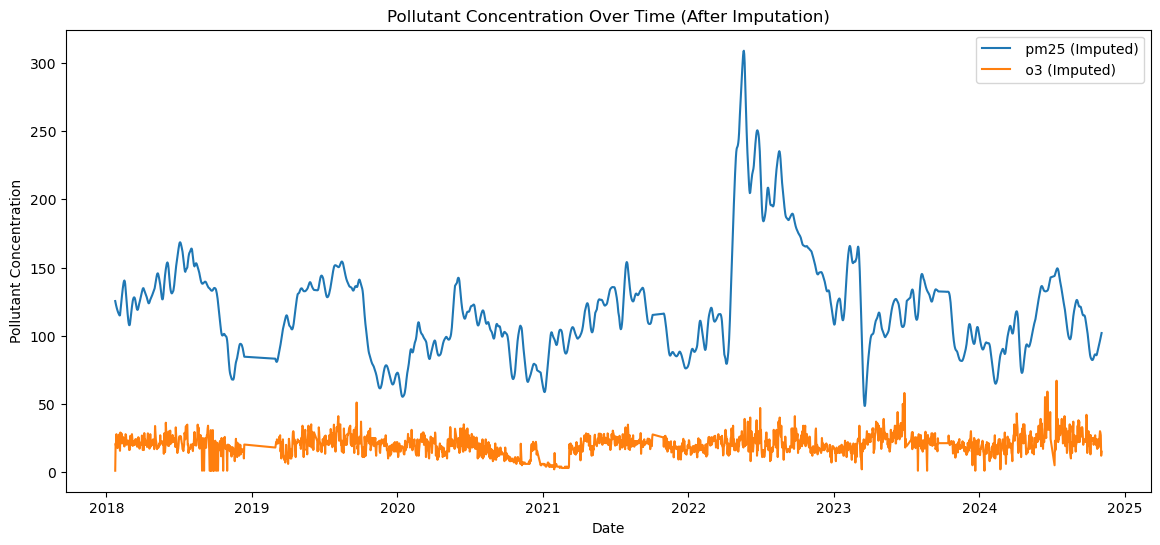

In [17]:
plt.figure(figsize=(14, 6))
for column in data.columns:
    plt.plot(data_imputed.index, data_imputed[column], label=f'{column} (Imputed)')
plt.xlabel('Date')
plt.ylabel('Pollutant Concentration')
plt.title('Pollutant Concentration Over Time (After Imputation)')
plt.legend()
plt.show()

In [18]:
from scipy.signal import savgol_filter

data_imputed[' pm25'] = savgol_filter(data_imputed[' pm25'], window_length=15, polyorder=2)
data_imputed[' o3'] = savgol_filter(data_imputed[' o3'], window_length=15, polyorder=2)

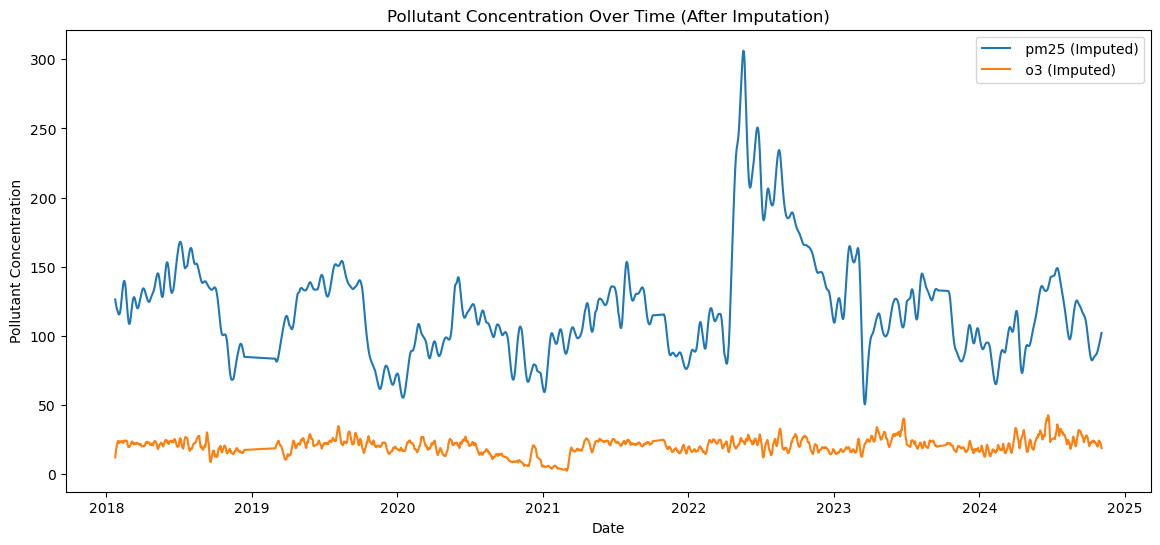

In [19]:
plt.figure(figsize=(14, 6))
for column in data.columns:
    plt.plot(data_imputed.index, data_imputed[column], label=f'{column} (Imputed)')
plt.xlabel('Date')
plt.ylabel('Pollutant Concentration')
plt.title('Pollutant Concentration Over Time (After Imputation)')
plt.legend()
plt.show()

In [20]:
# to prepare data for LSTM model
def prepare_data(series, n_steps):
    X, y = [], []
    for i in range(len(series)):
        end_ix = i + n_steps
        if end_ix > len(series) - 1:
            break
        seq_x, seq_y = series[i:end_ix], series[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [38]:
data_imputed.to_csv('processed-dubai-us embassy-air-quality.csv', index=True)


In [22]:
scalers = {}
scaled_data = {}
for pollutant in data.columns:
    scaler = MinMaxScaler()
    scaled_series = scaler.fit_transform(data_imputed[[pollutant]])
    scalers[pollutant] = scaler
    scaled_data[pollutant] = scaled_series

In [39]:
scalers

{' pm25': MinMaxScaler(), ' o3': MinMaxScaler()}

In [45]:
import joblib

scaler_pm25 = MinMaxScaler().fit(data_imputed[' pm25'].values.reshape(-1, 1))
scaler_o3 = MinMaxScaler().fit(data_imputed[' o3'].values.reshape(-1, 1))

joblib.dump(scaler_pm25, 'scaler_pm25_usembassy.pkl')
joblib.dump(scaler_o3, 'scaler_o3_usembassy.pkl')

['scaler_o3_usembassy.pkl']

In [46]:
scaler = joblib.load('scaler_pm25_usembassy.pkl')
print(type(scaler))

<class 'sklearn.preprocessing._data.MinMaxScaler'>


Epoch 1/50


C:\Users\Durga\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 - 5s - 89ms/step - loss: 0.0125 - val_loss: 0.0011
Epoch 2/50
57/57 - 2s - 35ms/step - loss: 0.0025 - val_loss: 7.9388e-04
Epoch 3/50
57/57 - 1s - 19ms/step - loss: 0.0015 - val_loss: 5.9866e-04
Epoch 4/50
57/57 - 1s - 17ms/step - loss: 0.0012 - val_loss: 5.9233e-04
Epoch 5/50
57/57 - 1s - 13ms/step - loss: 0.0010 - val_loss: 4.8724e-04
Epoch 6/50
57/57 - 1s - 17ms/step - loss: 9.0787e-04 - val_loss: 4.7599e-04
Epoch 7/50
57/57 - 1s - 15ms/step - loss: 7.8010e-04 - val_loss: 4.0636e-04
Epoch 8/50
57/57 - 1s - 14ms/step - loss: 7.1343e-04 - val_loss: 3.5953e-04
Epoch 9/50
57/57 - 1s - 14ms/step - loss: 5.7203e-04 - val_loss: 3.6626e-04
Epoch 10/50
57/57 - 1s - 13ms/step - loss: 4.5876e-04 - val_loss: 4.7264e-04
Epoch 11/50
57/57 - 1s - 13ms/step - loss: 4.6864e-04 - val_loss: 2.1361e-04
Epoch 12/50
57/57 - 1s - 17ms/step - loss: 2.8816e-04 - val_loss: 2.2752e-04
Epoch 13/50
57/57 - 1s - 13ms/step - loss: 2.2236e-04 - val_loss: 1.5112e-04
Epoch 14/50
57/57 - 1s - 12ms/step - loss: 

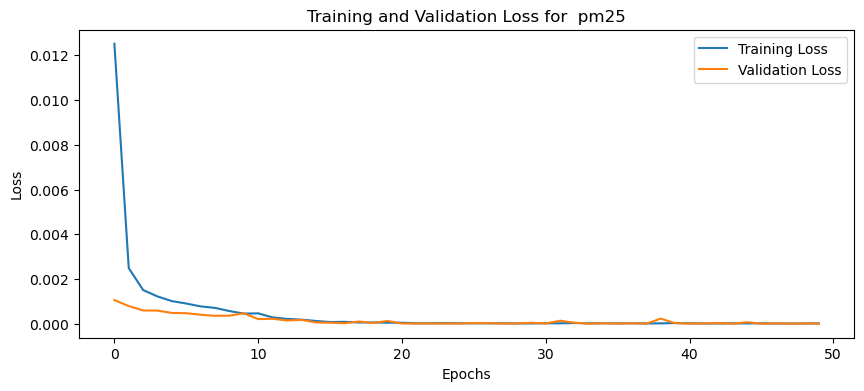

Epoch 1/50
57/57 - 5s - 92ms/step - loss: 0.0692 - val_loss: 0.0056
Epoch 2/50
57/57 - 2s - 36ms/step - loss: 0.0082 - val_loss: 0.0052
Epoch 3/50
57/57 - 1s - 26ms/step - loss: 0.0070 - val_loss: 0.0050
Epoch 4/50
57/57 - 1s - 21ms/step - loss: 0.0063 - val_loss: 0.0045
Epoch 5/50
57/57 - 1s - 25ms/step - loss: 0.0055 - val_loss: 0.0050
Epoch 6/50
57/57 - 1s - 18ms/step - loss: 0.0052 - val_loss: 0.0037
Epoch 7/50
57/57 - 2s - 27ms/step - loss: 0.0048 - val_loss: 0.0035
Epoch 8/50
57/57 - 1s - 21ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 9/50
57/57 - 1s - 22ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 10/50
57/57 - 1s - 21ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 11/50
57/57 - 2s - 27ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 12/50
57/57 - 1s - 21ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 13/50
57/57 - 1s - 21ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 14/50
57/57 - 1s - 20ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 15/50
57/57 - 1s - 20ms/step - loss: 

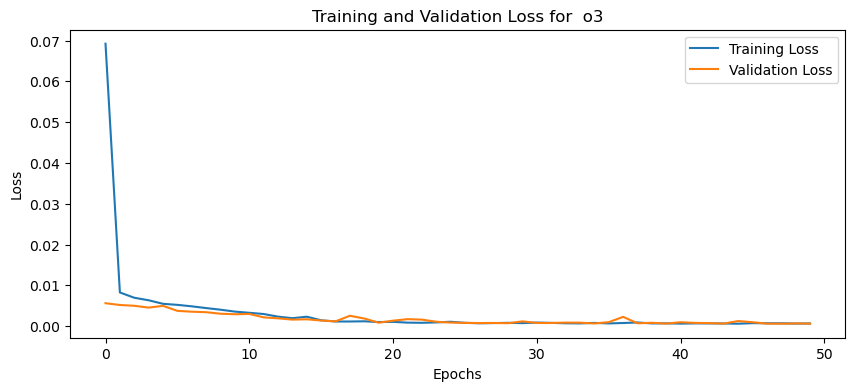

In [31]:
train_size = 0.8  # 80% training, 20% validation
train_data = {}
val_data = {}

for pollutant in data.columns:
    series_length = len(scaled_data[pollutant])
    train_end = int(train_size * series_length)
    train_data[pollutant], val_data[pollutant] = scaled_data[pollutant][:train_end], scaled_data[pollutant][train_end - 30:]  # Include a buffer for validation sequence

models = {}
histories = {}
n_steps = 30  # Number of past days for prediction

for pollutant in data.columns:
    X_train, y_train = prepare_data(train_data[pollutant], n_steps)
    X_val, y_val = prepare_data(val_data[pollutant], n_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # Reshape for LSTM
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

    # Bi-LSTM model
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=2)
    models[pollutant] = model
    histories[pollutant] = history

    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {pollutant}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [49]:
future_steps = 7  # Number of days to predict
predictions = {}

for pollutant, model in models.items():
    pollutant_name = pollutant
    input_seq = scaled_data[pollutant_name][-n_steps:].reshape(1, n_steps, 1)
    predicted_values = []
    for _ in range(future_steps):
        pred = model.predict(input_seq, verbose=0)
        predicted_values.append(pred[0][0])
        pred_reshaped = pred.reshape(1, 1, 1)
        input_seq = np.append(input_seq[:, 1:, :], pred_reshaped, axis=1)  # Slide the window
    predictions[pollutant] = scalers[pollutant_name].inverse_transform(np.array(predicted_values).reshape(-1, 1))

aqi_forecast = np.max([predictions[pollutant] for pollutant in predictions], axis=0)

dates = pd.date_range(data.index[-1] + pd.Timedelta(days=1), periods=future_steps)
prediction_df = pd.DataFrame(aqi_forecast, index=dates, columns=['Predicted AQI'])

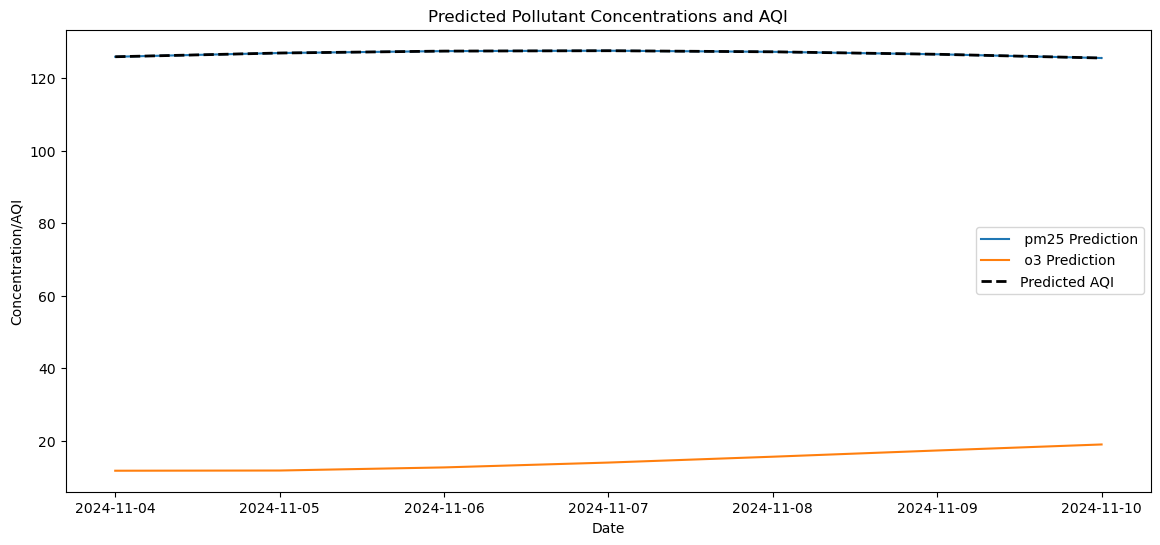

Predicted AQI for the next 7 days:
            Predicted AQI
2024-11-04     125.914772
2024-11-05     126.941544
2024-11-06     127.472198
2024-11-07     127.574997
2024-11-08     127.273743
2024-11-09     126.596191
2024-11-10     125.565651


In [50]:
plt.figure(figsize=(14, 6))
for pollutant in predictions:
    plt.plot(dates, predictions[pollutant], label=f'{pollutant} Prediction')
plt.plot(dates, aqi_forecast, 'k--', label='Predicted AQI', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Concentration/AQI')
plt.title('Predicted Pollutant Concentrations and AQI')
plt.legend()
plt.show()

print("Predicted AQI for the next 7 days:")
print(prediction_df)


In [34]:
models

{' pm25': <Sequential name=sequential_4, built=True>,
 ' o3': <Sequential name=sequential_5, built=True>}

In [51]:
for model_name, model in models.items():
    model.save(f'{model_name}_trainedmodel.keras')

In [91]:
predictions

{'pm25': array([[125.91477],
        [126.94154],
        [127.4722 ],
        [127.575  ],
        [127.27374],
        [126.59619],
        [125.56565]], dtype=float32),
 'o3': array([[11.778454],
        [11.83506 ],
        [12.691278],
        [14.027169],
        [15.642162],
        [17.357874],
        [19.017862]], dtype=float32)}

In [90]:
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import MinMaxScaler

model_pm25 = load_model('pm25_trainedmodel.keras')
model_o3 = load_model('o3_trainedmodel.keras')

data = pd.read_csv('processed-dubai-us embassy-air-quality.csv', parse_dates=['date'], index_col='date')
data[' pm25'] = pd.to_numeric(data[' pm25'], errors='coerce')
data[' o3'] = pd.to_numeric(data[' o3'], errors='coerce')


data.columns = data.columns.str.strip()


scaler_pm25 = MinMaxScaler()
scaler_o3 = MinMaxScaler()

data['pm25'] = scaler_pm25.fit_transform(data['pm25'].values.reshape(-1, 1))
data['o3'] = scaler_o3.fit_transform(data['o3'].values.reshape(-1, 1))

input_data = {
    'pm25': data['pm25'].values[-30:],  # Get the last 30 values as an array
    'o3': data['o3'].values[-30:]       # Get the last 30 values as an array
}

print("Scaled data (last 30 days):", input_data)

future_steps = 7  # Number of days to predict
predictions = {}

for pollutant, model in {'pm25': model_pm25, 'o3': model_o3}.items():
    input_seq = input_data[pollutant].reshape(1, 30, 1)  # Reshape for model input
    predicted_values = []
    for _ in range(future_steps):
        pred = model.predict(input_seq, verbose=0)
        predicted_values.append(pred[0][0])
        pred_reshaped = pred.reshape(1, 1, 1)
        input_seq = np.append(input_seq[:, 1:, :], pred_reshaped, axis=1)  # Slide the window
    predictions[pollutant] = eval(f"scaler_{pollutant}").inverse_transform(np.array(predicted_values).reshape(-1, 1))

aqi_forecast = np.max([predictions[pollutant] for pollutant in predictions], axis=0)

dates = pd.date_range(data.index[-1] + pd.Timedelta(days=1), periods=future_steps)
prediction_df = pd.DataFrame(aqi_forecast, index=dates, columns=['Predicted AQI'])

print("Predictions for each pollutant:", predictions)
print("Predicted AQI for the next 7 days:")
print(prediction_df)


C:\Users\Durga\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Scaled data (last 30 days): {'pm25': array([0.28925049, 0.30430561, 0.31827355, 0.33029148, 0.33967645,
       0.34597698, 0.3489919 , 0.34871102, 0.34530268, 0.33909919,
       0.33054686, 0.31972169, 0.30771326, 0.29562543, 0.28430132,
       0.27432421, 0.26610586, 0.25994077, 0.25598727, 0.25425896,
       0.25460315, 0.25669174, 0.26008761, 0.26276324, 0.26628682,
       0.27065834, 0.27587781, 0.28194523, 0.28886059, 0.29662389]), 'o3': array([0.5371778 , 0.54284273, 0.5344399 , 0.53784426, 0.54205469,
       0.54670641, 0.5292478 , 0.53078336, 0.51896716, 0.49756381,
       0.52099807, 0.53233244, 0.52236702, 0.52573536, 0.52137183,
       0.51491885, 0.52494281, 0.53159843, 0.5233397 , 0.50051336,
       0.49747375, 0.50599816, 0.53640777, 0.51663696, 0.48934834,
       0.45454192, 0.41221769, 0.36237565, 0.30501581, 0.24013816])}
Predictions for each pollutant: {'pm25': array([[125.91477],
       [126.94154],
       [127.4722 ],
       [127.575  ],
       [127.27374],
       [

In [92]:
def forecast_aqi(data, models, scalers, future_steps=7):
    data.columns = data.columns.str.strip()
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

    scaled_data = {}
    for col, scaler in scalers.items():
        scaled_data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
        data[col] = scaled_data[col]

    predictions = {}
    for pollutant, model, scaler in models:
        input_seq = data[pollutant].tail(30).values.reshape(1, 30, 1)
        predicted_values = []
        for _ in range(future_steps):
            pred = model.predict(input_seq, verbose=0)
            predicted_values.append(pred[0][0])
            pred_reshaped = pred.reshape(1, 1, 1)
            input_seq = np.append(input_seq[:, 1:, :], pred_reshaped, axis=1)  # Slide the window
        predictions[pollutant] = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))

    aqi_forecast = np.max([predictions['pm25'], predictions['o3']], axis=0)

    last_date = pd.to_datetime(data.index[-1])
    dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=future_steps)
    prediction_df = pd.DataFrame(aqi_forecast, index=dates, columns=['Predicted AQI'])

    return prediction_df, predictions


model_pm25 = load_model('pm25_trainedmodel.keras')
model_o3 = load_model('o3_trainedmodel.keras')

scaler_pm25 = MinMaxScaler()
scaler_o3 = MinMaxScaler()
models = [('pm25', model_pm25, scaler_pm25), ('o3', model_o3, scaler_o3)]
scalers = {'pm25': scaler_pm25, 'o3': scaler_o3}


data = pd.read_csv('processed-dubai-us embassy-air-quality.csv', parse_dates=['date'], dayfirst=True)
data.set_index('date', inplace=True)
data = data.sort_index()


prediction_df, predictions = forecast_aqi(data, models, scalers)


aqi_forecast = np.max([predictions['pm25'], predictions['o3']], axis=0)


last_date = pd.to_datetime(data.index[-1])
dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=7)
prediction_df = pd.DataFrame(aqi_forecast, index=dates, columns=['Predicted AQI'])
predictions

C:\Users\Durga\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


{'pm25': array([[101.91537],
        [102.41908],
        [102.46145],
        [102.07231],
        [101.26428],
        [100.06022],
        [ 98.49124]], dtype=float32),
 'o3': array([[18.385004],
        [18.301115],
        [18.692142],
        [19.388144],
        [20.271912],
        [21.233398],
        [22.17659 ]], dtype=float32)}

In [93]:
last_date = pd.to_datetime(data.index[-1])
dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=7)
dates

DatetimeIndex(['2024-11-04', '2024-11-05', '2024-11-06', '2024-11-07',
               '2024-11-08', '2024-11-09', '2024-11-10'],
              dtype='datetime64[ns]', freq='D')

In [94]:
print("Length of dates:", len(dates))
print("Length of PM2.5 predictions:", len(predictions['pm25']))
print("Length of O3 predictions:", len(predictions['o3']))


Length of dates: 7
Length of PM2.5 predictions: 7
Length of O3 predictions: 7


In [95]:
print("PM2.5 Predictions:", predictions['pm25'])
print("O3 Predictions:", predictions['o3'])


PM2.5 Predictions: [[101.91537]
 [102.41908]
 [102.46145]
 [102.07231]
 [101.26428]
 [100.06022]
 [ 98.49124]]
O3 Predictions: [[18.385004]
 [18.301115]
 [18.692142]
 [19.388144]
 [20.271912]
 [21.233398]
 [22.17659 ]]


In [103]:
predictions['pm25'].reshape(1,-1)

array([[101.91537, 102.41908, 102.46145, 102.07231, 101.26428, 100.06022,
         98.49124]], dtype=float32)

In [104]:
predictions

{'pm25': array([[101.91537],
        [102.41908],
        [102.46145],
        [102.07231],
        [101.26428],
        [100.06022],
        [ 98.49124]], dtype=float32),
 'o3': array([[18.385004],
        [18.301115],
        [18.692142],
        [19.388144],
        [20.271912],
        [21.233398],
        [22.17659 ]], dtype=float32)}

In [105]:
aqi_forecast = np.max(np.hstack([values for values in predictions.values()]), axis=1)

In [106]:
aqi_forecast

array([101.91537, 102.41908, 102.46145, 102.07231, 101.26428, 100.06022,
        98.49124], dtype=float32)

In [107]:
last_date = pd.to_datetime(data.index[-1])
dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=7)
prediction_df = pd.DataFrame(aqi_forecast, index=dates, columns=['Predicted AQI'])

In [115]:
prediction_df.iloc[0][0]

101.91537